# **Gradient Boosting Implementation**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import GradientBoostingRegressor

## Intuition

Boosting is a method that combines several simple models into one complex one. The idea is that by adding new simple models, the overall model becomes more accurate in forecasting.

In boosting, simple models are called base models.

Gradient boosting is a learning method in which we use not just residuals, but pseudo-residuals. As a result, we get a model consisting of several simple decision trees.

## Introduction
---
The model looks like this:

$F(x) = F_0(x) + \sum_{m=1}^M \nu h_m(x)$,

---  

Where:
- $F_0(x)$ —  is the initial approximation,
- $h_m(x)$ is the weak model at iteration $m$,
- and $\nu$ is the learning rate.

## Core Idea
---
Initially, the model $F_0(x)$ approximates the true dependency roughly. Each subsequent model corrects the errors of the previous model by adding predictions based on the gradient of the loss function.

At the $n$-th iteration, the gradient of the loss function $L(y, F(x))$ is computed to update the model:  
$r_{i,m} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F(x)=F_{m-1}(x)}$,


where $r_{i,m}$ is the residual (error) of the current model.


---
This residual is used to train a weak model $h_m(x)$, which minimizes the deviation:  
$h_m = \arg\min_h \sum_{i=1}^N (r_{i,m} - h(x_i))^2$.


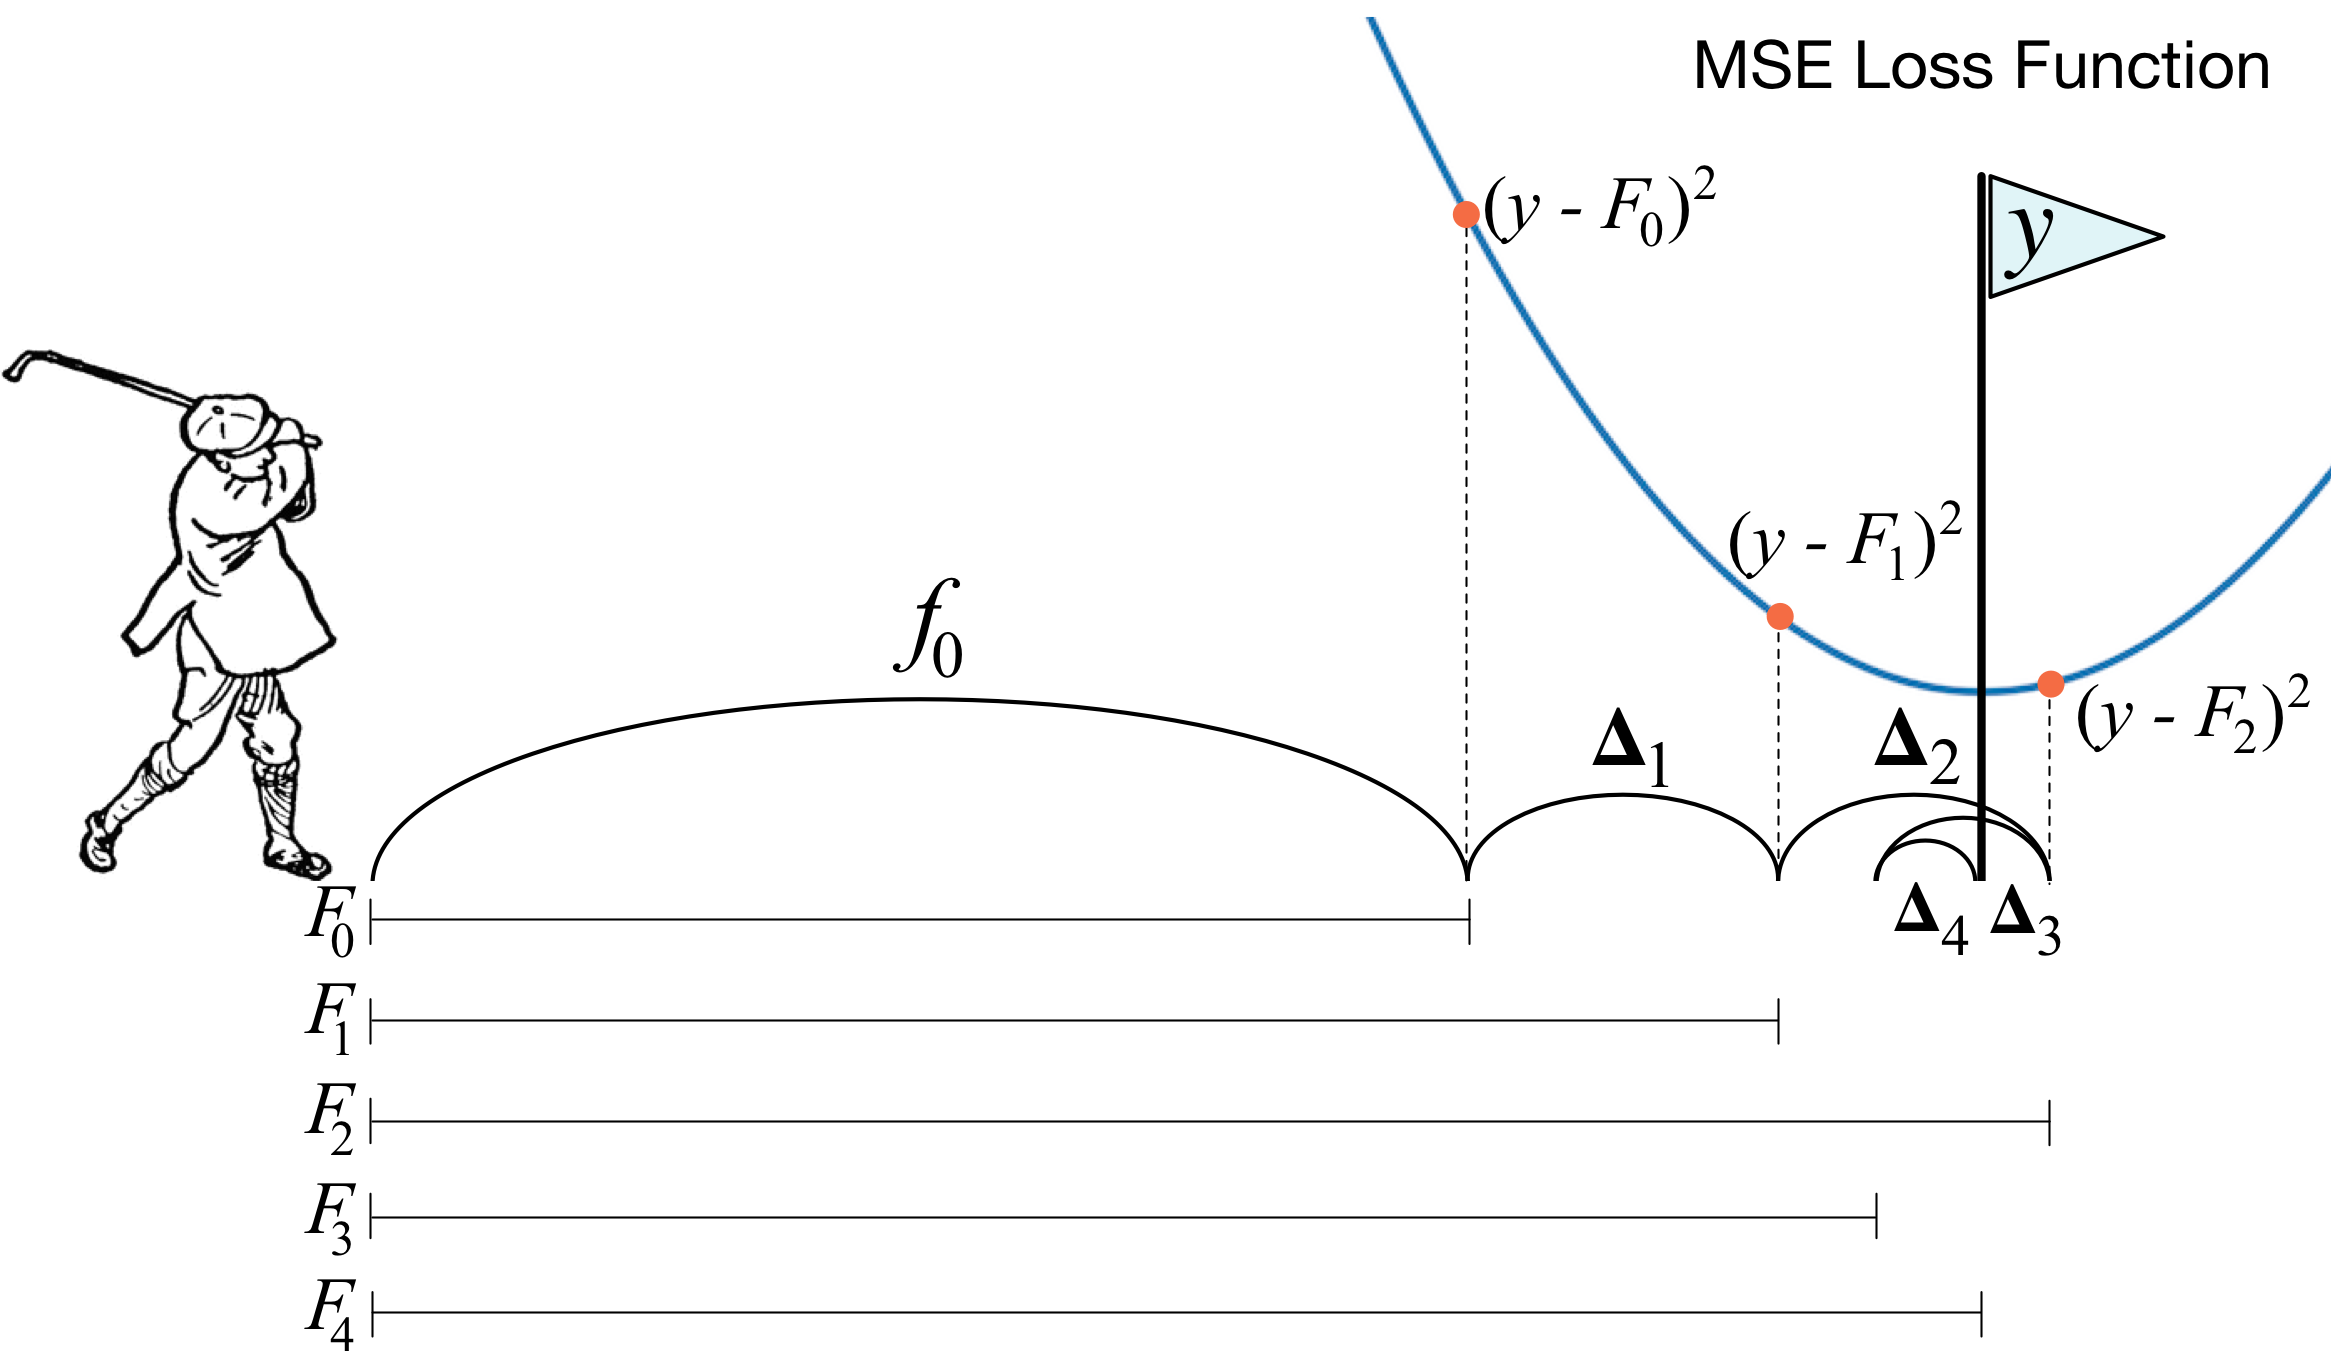

A source: https://explained.ai/gradient-boosting/descent.html

## Optimization
---
The loss function can vary depending on the task:

- For regression:  
  $L(y, F(x)) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$
- For classification:  
  $L(y, F(x)) = -\sum_{i=1}^n \left[y_i \log(\hat{p}_i) + (1 - y_i) \log(1 - \hat{p}_i)\right]$,  
  where $\hat{p}_i$ is the probability of belonging to a class.

---
  In this project we will only consider regression.

## Iterative Process
---
If the algorithm consists of $M$ iterations, the model is updated as follows:

1. **Initialization:**  
   $F_0(x) = \arg\min_c \sum_{i=1}^n L(y_i, c)$.
2. **At each iteration:**  
   - Compute the gradient:  
     $r_{i,m} = y_i - F_{m-1}(x_i)$.
   - Train a weak model $h_m(x)$ on $r_{i,m}$.
   - Update the model:  
     $F_m(x) = F_{m-1}(x) + \nu h_m(x)$.


    


## Final Model
---
After $M$ iterations, the final model is:  
$F_M(x) = F_0(x) + \sum_{m=1}^M \nu h_m(x)$.

## Example

We use synthetic data on 20 houses, including their price and area. Using a small amount of data will allow us to understand the essence of the algorithm and focus on its study.

In [ ]:
data = {'house_area': {0: 8450, 1: 9600, 2: 11250, 3: 9550, 4: 14260,
                       5: 14115, 6: 10084, 7: 10382, 8: 6120, 9: 7420, 10: 11200,
                       11: 11924, 12: 12968, 13: 10652, 14: 10920, 15: 6120,
                       16: 11241, 17: 10791, 18: 13695, 19: 7560},

         'price':{0: 208500, 1: 181500,  2: 223500, 3: 140000, 4: 250000,
                  5: 143000, 6: 307000, 7: 200000, 8: 129900, 9: 118000,
                  10: 129500, 11: 345000, 12: 144000, 13: 279500, 14: 157000,
                  15: 132000, 16: 149000, 17: 90000, 18: 159000, 19: 139000}}

In [ ]:
df = pd.DataFrame(data) # Table view
df.head(3) # View 3 lines

,house_area,price
0,8450,208500
1,9600,181500
2,11250,223500


Visualize data

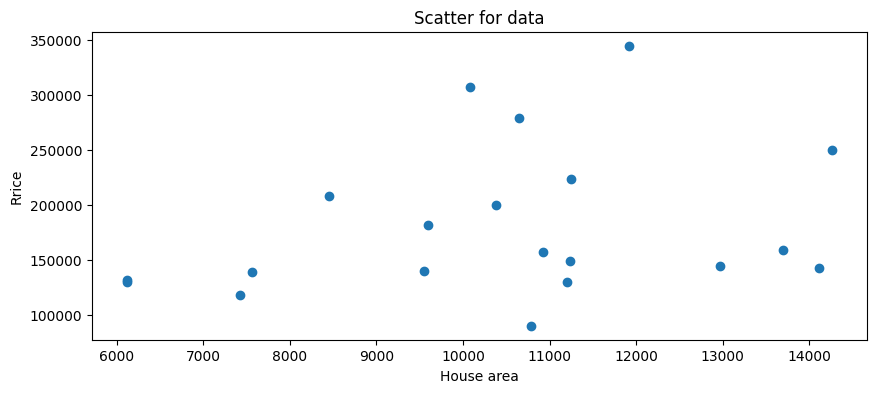

In [ ]:
plt.figure(figsize=(10,4))
plt.scatter(df['house_area'],df['price'])
plt.title('Scatter for data')
plt.xlabel('House area')
plt.ylabel('Rrice')
plt.show()

## Initialization and the first step

To begin, we will use the average cost as the initial model:
$F_1 = \bar{y}$

In [ ]:
df['predict_1'] = df['price'].mean() # mean as first prediction
df['residual'] = df['price'] - df['predict_1'] # error or residual
df.head()

,house_area,price,predict_1,residual
0,8450,208500,181270.0,27230.0
1,9600,181500,181270.0,230.0
2,11250,223500,181270.0,42230.0
3,9550,140000,181270.0,-41270.0
4,14260,250000,181270.0,68730.0


For further training, a simple model will be used, in this case a tree with depth 1. This model will take into account the new residual estimate, equal to $r_{im}$.

In [ ]:
# creating a weak model
tree = DecisionTreeRegressor(random_state=0, max_depth=1) # Limits tree depth to one level
tree.fit(df[['house_area']], df[['residual']]) # tree training on 'residual'
df['predict_2'] = df['predict_1'] + 1*tree.predict(df[['house_area']]) # prediction update
df.head()

,house_area,price,predict_1,residual,predict_2
0,8450,208500,181270.0,27230.0,194156.25
1,9600,181500,181270.0,230.0,194156.25
2,11250,223500,181270.0,42230.0,194156.25
3,9550,140000,181270.0,-41270.0,194156.25
4,14260,250000,181270.0,68730.0,194156.25


Let's check if the error has decreased

In [ ]:
mse(df['price'], df['predict_2']) < mse(df['price'], df['predict_1'])

True

Let's visualize this

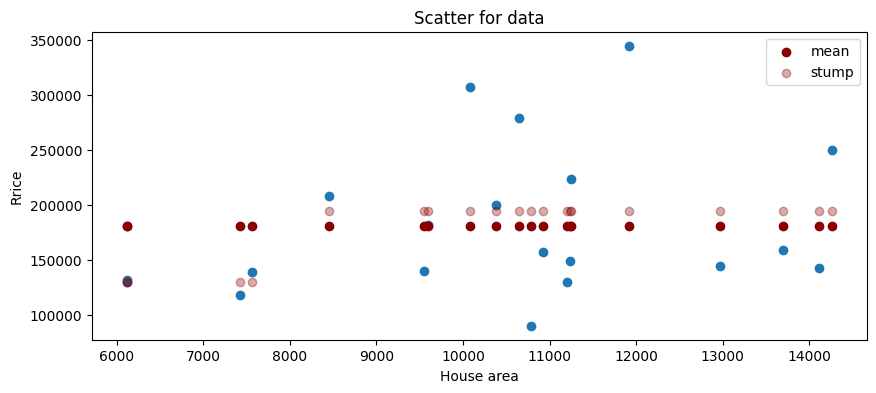

In [ ]:
plt.figure(figsize=(10,4))
plt.scatter(df['house_area'],df['price'])
plt.scatter(df['house_area'],df['predict_1'],color='#8B0000', alpha=1, label='mean')
plt.scatter(df['house_area'],df['predict_2'],color='#8B0000', alpha=1/3, label='stump')
plt.legend()
plt.title('Scatter for data')
plt.xlabel('House area')
plt.ylabel('Rrice')
plt.show()

The model demonstrates a deeper understanding of the patterns in our data than just the average.

## Learning using gradient descent method.
---
Next, you need to write code that will repeatedly calculate gradients, train trees of depth 1, update and save predictions for the current iteration. All actions will be similar to those performed last time, only they will be repeated many times.

---
However, the first prediction will be zero, which will allow us to clearly demonstrate the learning process in the visualization.

In [ ]:
df.head(3)

,house_area,price,predict_1,residual,predict_2
0,8450,208500,181270.0,27230.0,194156.25
1,9600,181500,181270.0,230.0,194156.25
2,11250,223500,181270.0,42230.0,194156.25


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   house_area  20 non-null     int64  
 1   price       20 non-null     int64  
 2   predict_1   20 non-null     float64
 3   residual    20 non-null     float64
 4   predict_2   20 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 960.0 bytes


In [ ]:
def Gradient_Boosting_Regressor(df, n_iterations=1000, learning_rate=1):
  predictions_dict = {}
  losses = {}
  df['predict_1'] = 0

  for iteration in range(n_iterations):
    df['residual'] = df['price'] - df['predict_1']
    tree = DecisionTreeRegressor(random_state=0, max_depth=1)
    tree.fit(df[['house_area']], df['residual'])

    df['predict_1'] += learning_rate * tree.predict(df[['house_area']])
    predictions_dict[iteration + 1] = df['predict_1'].copy()
    losses[iteration + 1] = np.sqrt(mse(df['price'], df['predict_1']))

  return predictions_dict, losses

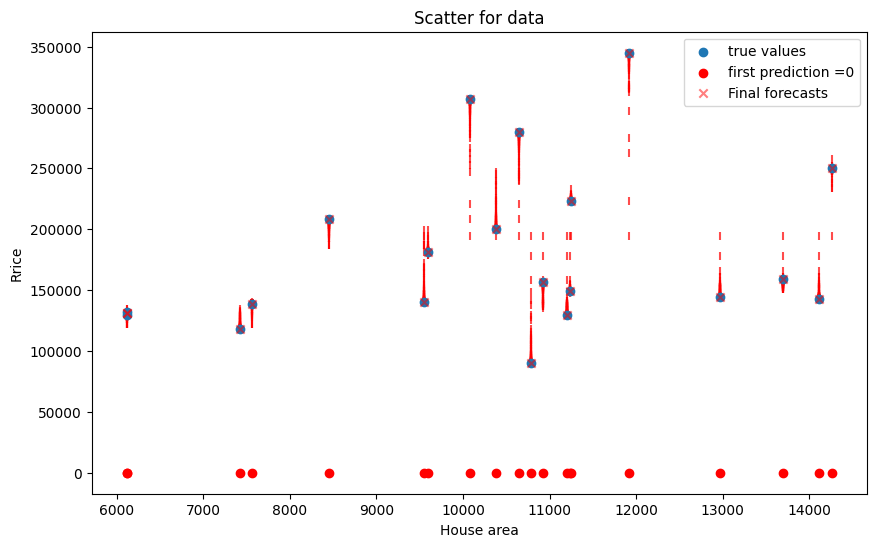

In [ ]:
n_iterations = 1000
learning_rate = 1


manual_G_B = Gradient_Boosting_Regressor(df,n_iterations, learning_rate)[0]

plt.figure(figsize=(10,6))
for i in range(1, n_iterations,5):
  plt.scatter(df['house_area'], manual_G_B[i], alpha=0.7, color='r', marker="|")

plt.scatter(df['house_area'],df['price'], label='true values')
plt.scatter(df['house_area'], np.zeros(20), color='r', marker="o", alpha=1, label='first prediction =0')
plt.scatter(df['house_area'], manual_G_B[n_iterations], color='r', marker="x", alpha=0.5, label='Final forecasts')
plt.title('Scatter for data')
plt.xlabel('House area')
plt.ylabel('Rrice')
plt.legend()
plt.show()

## About the learning rate

Let's check the compliance of our house price forecast with real prices. To assess the quality of the forecast, we use the following formula:

---
$$
\text{Percentage Error} = \frac{\text{MSE}}{\text{price.mean()}} \times 100\%
$$

In [ ]:
per_error = round((np.sqrt(mse(manual_G_B[n_iterations], df['price']))) /df['price'].mean()*100,2)
print(per_error)

0.18


This formula gives the percentage value of the prediction error relative to actual prices. This is a relatively small error compared to the overall price, and the model predicts prices quite accurately.

Let us consider the dynamics of convergence of the RMSE error at different learning rates.

In [ ]:
learning_rates = [0.01, 0.05, 0.1, 0.5, 1]
losses = {}

for rate in learning_rates:
    _, loss_for_rate = Gradient_Boosting_Regressor(df, n_iterations, rate)
    losses[rate] = loss_for_rate

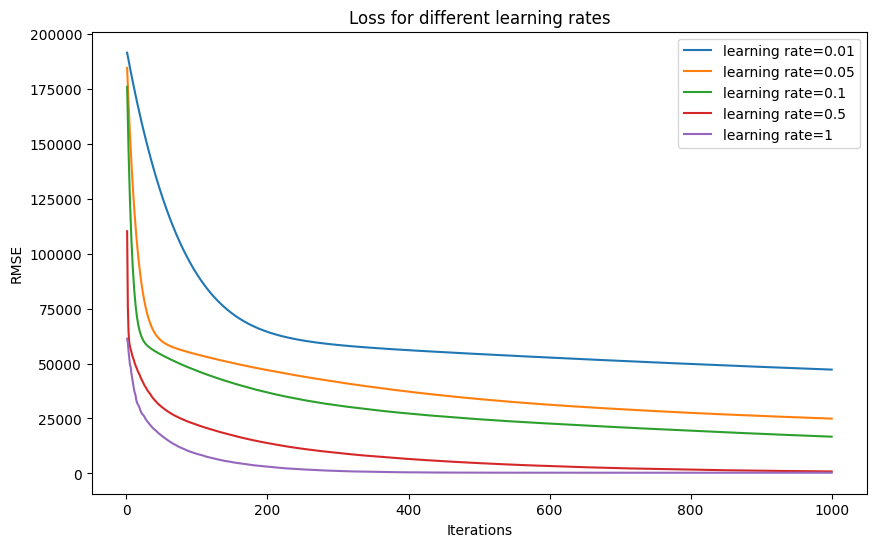

In [ ]:
plt.figure(figsize=(10,6))

for rate, loss in losses.items():
    plt.plot(list(loss.keys()), list(loss.values()), label=f'learning rate={rate}')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Loss for different learning rates')
plt.legend()
plt.show()

In this situation, the data and the error function are in balance, which avoids instability. Therefore, the optimal learning rate is 1, since at this value the learning process converges to 0 in the best way. However, this is not always the case, and it is necessary to select the appropriate\values for each case.

In [ ]:
GBRegressor = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=1,
    max_depth=1,
    loss='squared_error',
    random_state=0,
    subsample=1.0,
    min_samples_split=2,
    min_samples_leaf=1
)
GBRegressor.fit(df[['house_area']], df['price'])


sklearn_pred = pd.Series(GBRegressor.predict(df[['house_area']]), name='sklearn_pred')
manual_pred = pd.Series(manual_G_B[n_iterations], name='manual_pred')

df_predictions = pd.concat([manual_pred,
           sklearn_pred], axis=1)

df_predictions

,manual_pred,sklearn_pred
0,208497.904790,208497.904790
1,181499.954996,181499.954996
2,223502.312143,223502.312143
3,140002.148679,140002.148679
4,249999.498493,249999.498493
5,143000.573909,143000.573909
6,306997.980836,306997.980836
7,200002.106208,200002.106208
8,130949.764098,130949.764098
9,118001.624484,118001.624484


In [ ]:
round((np.sqrt(mse(df_predictions['manual_pred'], df_predictions['sklearn_pred']))) /df['price'].mean()*100,2)

0.0